In [ ]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import lib.io.stan

In [ ]:
with open(f'results/exp1/fitout_ns5_md8_chain1.csv','r') as fd1:
    with open('results/exp1/fitout_ns5_md8_chain1_wowarm.csv','w') as fd2:
        while(True):
            t = fd1.readline()
            if(t[0] == '#'):
                fd2.write(t)
            else:
                fd2.write(t)
                for i in range(200):
                    fd1.readline()
                break
        t = fd1.readline()
        while(t):
            fd2.write(t)
            t = fd1.readline()

In [ ]:
import os
import lib.io.stan


num_warmup_samples = 200
ns = 11
nchains = 8
for i in range(ns):
    for j in range(nchains):
        src_fname = f'results/exp1/fitout_ns{i+1}_md8_chain{j+1}.csv'
        if(os.path.isfile(src_fname)):
            trgt_fname = f'results/exp1/fitout_ns{i+1}_md8_chain{j+1}_wowarmup.csv'
            lib.io.stan.rem_warmup_samples(src_fname,trgt_fname,num_warmup_samples)
        else:
            print(f'File not found: {src_fname}')

In [ ]:
import os
import sys
import re
ptrn = re.compile('^fitout.*chain\d+.csv$')
fnames = os.listdir('results/exp1/')
t = []
for fname in fnames:
    if(ptrn.match(fname)):
        t.append(fname)
print(len(t))

In [ ]:
import sys
out = sys.stdout
out.write('sldfkj')

In [ ]:
import numpy as np

def read_samples(csv_fname,nwarmup,nsampling,ignore_warmup=False):
    if(ignore_warmup):
        nsamples = nsampling
    else:
        nsamples = nwarmup + nsampling
    with open(csv_fname,'r') as fd:
        t = fd.readline()
        read_head = False
        sample_idx = 0
        while(t):
    #         print(t[0:10])
            if(t[0] == '#'):
                t = fd.readline()
                continue
            elif(not read_head):
                var_names = []
                var_dims = {}
                col_names = t.split(',')
                for i,name in enumerate(col_names):
                    var_name = name.split('.')[0]
                    var_dim = [int(dim) for dim in name.split('.')[1:]]
                    if(var_name not in var_names):
                        var_names.append(var_name)
                    var_dims[var_name] = var_dim
                read_head = True
                data = {}
                for var_name in var_names:
                    data[var_name] = np.ndarray(shape = [nsamples] + var_dims[var_name],dtype=float)
            else:
                if(ignore_warmup):
                    for i in range(nwarmup):
                        t = fd.readline()
                    ignore_warmup = False
                    continue
                else:
                    var_vals = [float(el) for el in t.split(',')]
                    end_idx = 0
                    for var_name in var_names:
                        start_idx = end_idx
                        end_idx = start_idx + (np.product(var_dims[var_name]) if(var_dims[var_name]) else 1)
                        data[var_name][sample_idx] = np.array(var_vals[start_idx:end_idx]).reshape(var_dims[var_name],order='F')
                    sample_idx += 1
                    if(sample_idx == nsampling):
                        break
            t = fd.readline()
    return data

csv_fname = 'results/exp8/snsrs-1-2-3-4-5-6-7-8-9-10-11/samples_chain1.csv'
nwarmup = 500
nsampling = 5
ignore_warmup = True
hmc_samples = read_samples(csv_fname,nwarmup,nsampling,ignore_warmup)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import lib.io.stan

In [ ]:
csv_fname = 'results/exp8/snsrs-1-2-3-4-5-6-7-8-9-10-11/samples_chain1.csv'
nwarmup = 500
nsampling = 5
ignore_warmup = True
hmc_samples = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup)


plt.figure()
plt.violinplot(hmc_samples['x0']);

In [ ]:
for i in range(5):
    plt.figure()
    plt.plot(hmc_samples['x'][:,:,i].T);

In [ ]:
for key in hmc_samples.keys():
    print(f'{key}:{hmc_samples[key].shape}')

In [ ]:
import numpy as np

In [ ]:
import numpy as np
import lib.io.stan

np.random.seed(0)
SC = np.loadtxt('data/CJ/connectivity/weights.txt')
SC = SC / np.max(SC)
gain_mat = np.loadtxt('data/CJ/gain_inv-square.txt')

nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = 10*1000
I1 = 3.1
tau0 = 200.0

x0 = -2.5 * np.ones([nn])
ez = [6,34] 
pz = [22,13,9,27]
x0[ez] = -1.8
x0[pz] = -2.2
time_scale = 1.0
time_step = 0.1
sigma = 0.01
k = 2
epsilon = 0.1

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC,
        'gain': gain_mat, 'sigma':sigma, 'k':k, 'epsilon': epsilon, 'x0':x0,
        'time_scale':time_scale, 'time_step':time_step, 'x_init':x_init, 'z_init':z_init,
        'z_eta': z_eta}

lib.io.stan.rdump(f'tmp/sim_data.R',data)

stan_fname = './vep-forwardsim-2Depileptor'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
lib.io.stan.create_process(['sbatch','test.sh'],block=True)

In [ ]:
t1 = lib.io.stan.read_samples('tmp/sim_out.csv',0,1,True)

import matplotlib.pyplot as plt
%matplotlib inline
# print(t1.keys())
# print(np.shape(t1['x']))
srcSig = t1['x'][0,:,:]
regf = 0
regt = nn
plt.figure(figsize=(7,10))
plt.plot(srcSig/2.0 + np.r_[regf:regt], 'r');
# pyplt.plot(ttavg[:], tavgn.T + np.r_[regf:regt], 'r')
plt.yticks(np.mean(srcSig/2.0 + np.r_[regf:regt],axis=0), np.r_[regf:regt]+1,fontsize=7.0)
plt.title("Source signal")
plt.tight_layout()

In [ ]:
from lib.io import stan
csv_fname = 'results/exp8/snsrs-1-2-3-4-5-6-7-8-9-10-11/samples_chain1.csv'
nwarmup = 500
nsampling = 500
ignore_warmup = True
variables_of_interest = ['x0','lp__']
hmc_samples = stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest)

In [ ]:
np.shape(hmc_samples['lp__'])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.violinplot(hmc_samples['x0'][:,:]);
plt.figure()
plt.plot(hmc_samples['lp__'])


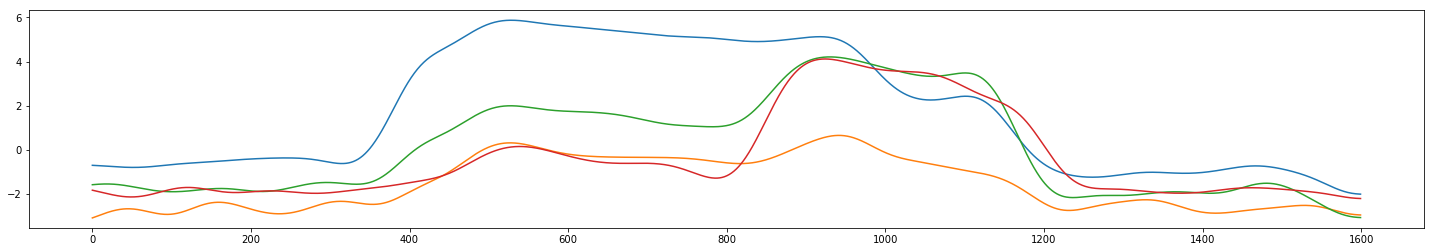

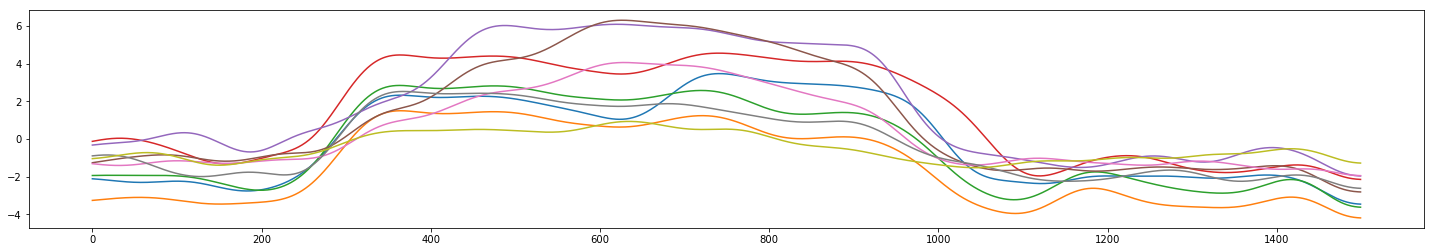

In [19]:
import numpy as np
fit_data = np.load('results/exp10/AC_fit_trgt.npz',)
plt.figure(figsize=(25,4));
plt.plot(fit_data['fit_trgt'][:,0::20]);

fit_data = np.load('results/exp10/CJ_fit_trgt.npz',)
plt.figure(figsize=(25,4));
plt.plot(fit_data['fit_trgt'][:,0::20]);